<a href="https://colab.research.google.com/github/aakhterov/ML_projects/blob/master/kaggle/breast_cancer_prediction/breast_cancer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Breast Canser Prediction**


This is a training project on the famous Kaggle [dataset](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data). There is also a detail analysis of this Dataset on [Coursera](https://www.coursera.org/projects/breast-cancer-prediction-using-machine-learning#details) and in general this project follows this analysis.  

**Short description** from Kaggle:

1) ID number

2) Diagnosis (M = malignant, B = benign)

3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)

b) texture (standard deviation of gray-scale values)

c) perimeter

d) area

e) smoothness (local variation in radius lengths)

f) compactness (perimeter^2 / area - 1.0)

g) concavity (severity of concave portions of the contour)

h) concave points (number of concave portions of the contour)

i) symmetry

j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant


# 1. Download dataset and import necessary packages, classes and functions

In [3]:
# !pip install python-dotenv

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [6]:
_ = load_dotenv("/content/drive/MyDrive/Colab Notebooks/Data/.env") # read local .env file

In [7]:
# Download dataset and ...
! kaggle datasets download -d uciml/breast-cancer-wisconsin-data

  0% 0.00/48.6k [00:00<?, ?B/s]
100% 48.6k/48.6k [00:00<00:00, 64.6MB/s]


In [8]:
# unzip it
! unzip /content/breast-cancer-wisconsin-data.zip

Archive:  /content/breast-cancer-wisconsin-data.zip
  inflating: data.csv                


#2. Exploratory Data Analysis

In [9]:
df = pd.read_csv('/content/data.csv')

In [10]:
df.head() # take a look at the data

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

In [11]:
df.shape

(569, 33)

In [12]:
df.isna().sum() # check NaN values

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [13]:
df.dropna(axis=1, inplace=True) # drop columns with NaN values

## 2.1. Univariate analysis

### 2.1.1. Target variable

In [14]:
df['diagnosis'].value_counts() # check target variable distribution

B    357
M    212
Name: diagnosis, dtype: int64

**Conclusion:** The dataset is imbalanced. Therefore we should either use some balancing technics or use weighted metrics.

### 2.1.2. Independent variable

In [15]:
 # take a look at the main tendencies.
df.describe()
# There is no something special except the fact that the variables have different scales and we should take this into account later

id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
count     569.000000  ...    569.000000     569.000000       569.000000   
mean        0.181162  ...     16.269190      25.677223       107.261213   
std         0.027414  ...      4.833242       6.146258        33.602542   
min         0.106000  ...      7.930000      12.020000        50.410000   
25%         0.161900  ...     13.010000      21.080000        84.110000   
50%         0.179200  ...     14.970000      25.410000        97.660000   
75%         0.195700  ...     18.790000      29.720000       125.400000   
max         0.304000  ...     36.040000      49.540000       251.200000   

        area_worst  smoothness_worst  compactness_worst  concavity_worst  \
count   569.000000        569.000000         569.000000       569.000000   
mean    880.583128          0.132369           0.254265         0.272188   
std     569.356993          0.022832           0.157336         0.208624   
min     185.200000          0.071170           0.027290         0.000000   
25%     515.300000          0.116600           0.147200         0.114500   
50%     686.500000          0.131300           0.211900         0.226700   
75%    1084.000000          0.146000           0.339100         0.382900   
max    4254.000000          0.222600           1.058000         1.252000   

       concave points_worst  symmetry_worst  fractal_dimension_worst  
count            569.000000      569.000000               569.000000  
mean               0.114606        0.290076                 0.083946  
std                0.065732        0.061867                 0.018061  
min                0.000000        0.156500                 0.055040  
25%                0.064930        0.250400                 0.071460  
50%                0.099930        0.282200                 0.080040  
75%                0.161400        0.317900                 0.092080  
max                0.291000        0.663800                 0.207500  

[8 rows x 31 columns]

In [21]:
# get column titles
num_vars = [col for col in df.columns.to_list() if col not in ['id', 'diagnosis']]
num_vars

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [46]:
# let's look at the outliers. We'are going to use a z-score to detect outliers.
# Recap that z-value = (x - mu)/sigma, where mu - the mean, sigma - the standard deviation
# We will count all samples that have z-value outside [-3, 3] as outliers
# We assume that all variables have normal distributions
outliers_indices = []
for col in num_vars:
  is_outlier = np.abs(zscore(df[col]))>3
  indices = df[is_outlier].index.to_list()
  outliers_indices += indices
  outliers_count = is_outlier.sum()
  print(f"Column {col}. Outliers count: {outliers_count}. Outlier indices = {indices}")

print(f"Total outliers: {len(set(outliers_indices))}")

Column radius_mean. Outliers count: 5. Outlier indices = [82, 180, 212, 352, 461]
Column texture_mean. Outliers count: 4. Outlier indices = [219, 232, 239, 259]
Column perimeter_mean. Outliers count: 7. Outlier indices = [82, 122, 180, 212, 352, 461, 521]
Column area_mean. Outliers count: 8. Outlier indices = [82, 122, 180, 212, 339, 352, 461, 521]
Column smoothness_mean. Outliers count: 5. Outlier indices = [3, 105, 122, 504, 568]
Column compactness_mean. Outliers count: 9. Outlier indices = [0, 3, 78, 82, 108, 122, 181, 258, 567]
Column concavity_mean. Outliers count: 9. Outlier indices = [78, 82, 108, 122, 152, 202, 352, 461, 567]
Column concave points_mean. Outliers count: 6. Outlier indices = [82, 108, 122, 180, 352, 461]
Column symmetry_mean. Outliers count: 5. Outlier indices = [25, 60, 78, 122, 146]
Column fractal_dimension_mean. Outliers count: 7. Outlier indices = [3, 71, 152, 318, 376, 504, 505]
Column radius_se. Outliers count: 7. Outlier indices = [122, 138, 212, 258, 417,

**Conclusion:** We have about 13% of outliers. We can either remove them or leave. Because we don't have strong pieces of evidence that these outliers are unnecessary, we leave them.      

## 2.2. Bivariate analysis

In [37]:
# Split our columns into 3 groups - the variables that represent mean values,
# the variables that represent standard deviation values, and the variables that represent the worst values
mean_vars = [col for col in num_vars if col.endswith('_mean')]
std_vars = [col for col in num_vars if col.endswith('_se')]
worst_vars = [col for col in num_vars if col.endswith('_worst')]

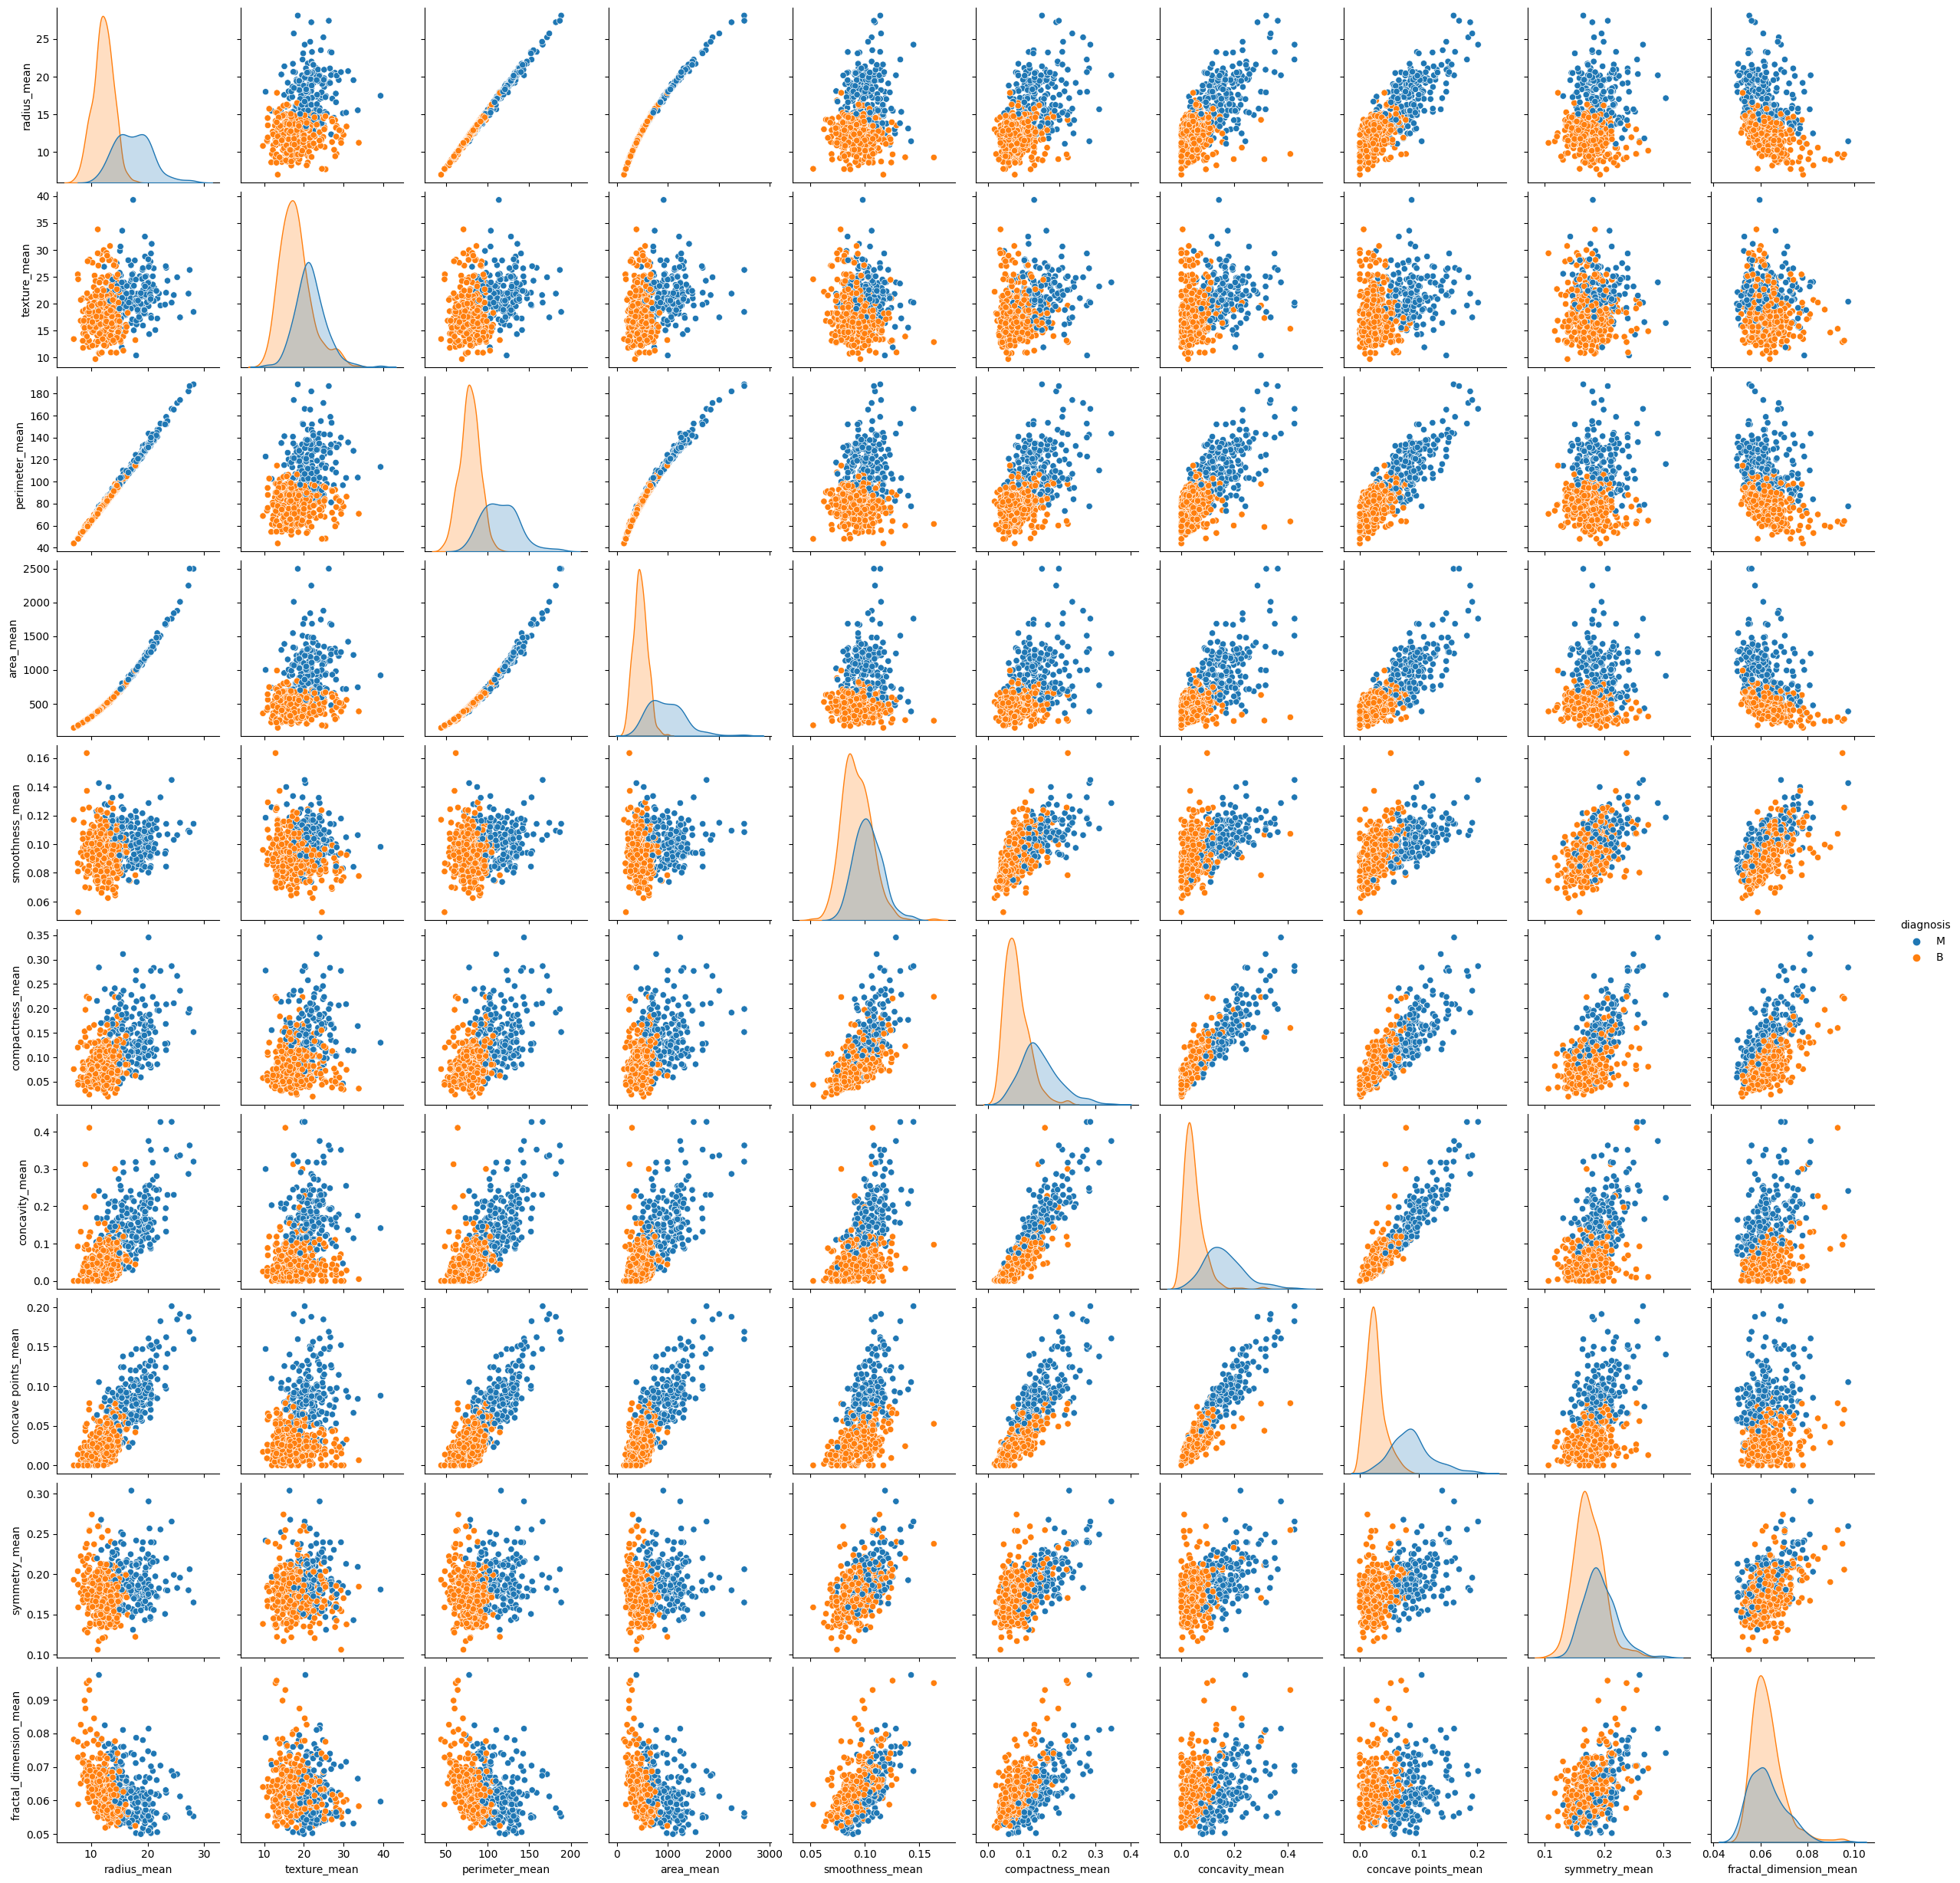

In [48]:
# Let's look at the pair dependencies of the 1 group variables.
sns.pairplot(data=df[mean_vars + ['diagnosis']], hue='diagnosis')

**Conclusion:**
1. We can see that there are a number of variables based on which we can good enough classify the target value
2. The following pairs of variables have a positive relation:
  - Radius_mean and Perimeter_mean
  - Radius_mean and Concavity_points_mean
  - Perimeter_mean and Concavity_points_mean
  - Concavity_mean and Concavity_points_mean
  - Concavity_mean and Compactness_mean
  - Concavity_points_mean and Compactness_mean
3. The following pairs have a quadratic relation (it doesn't look strange):
  - Area_mean and Radius_mean
  - Area_mean and Perimeter_mean

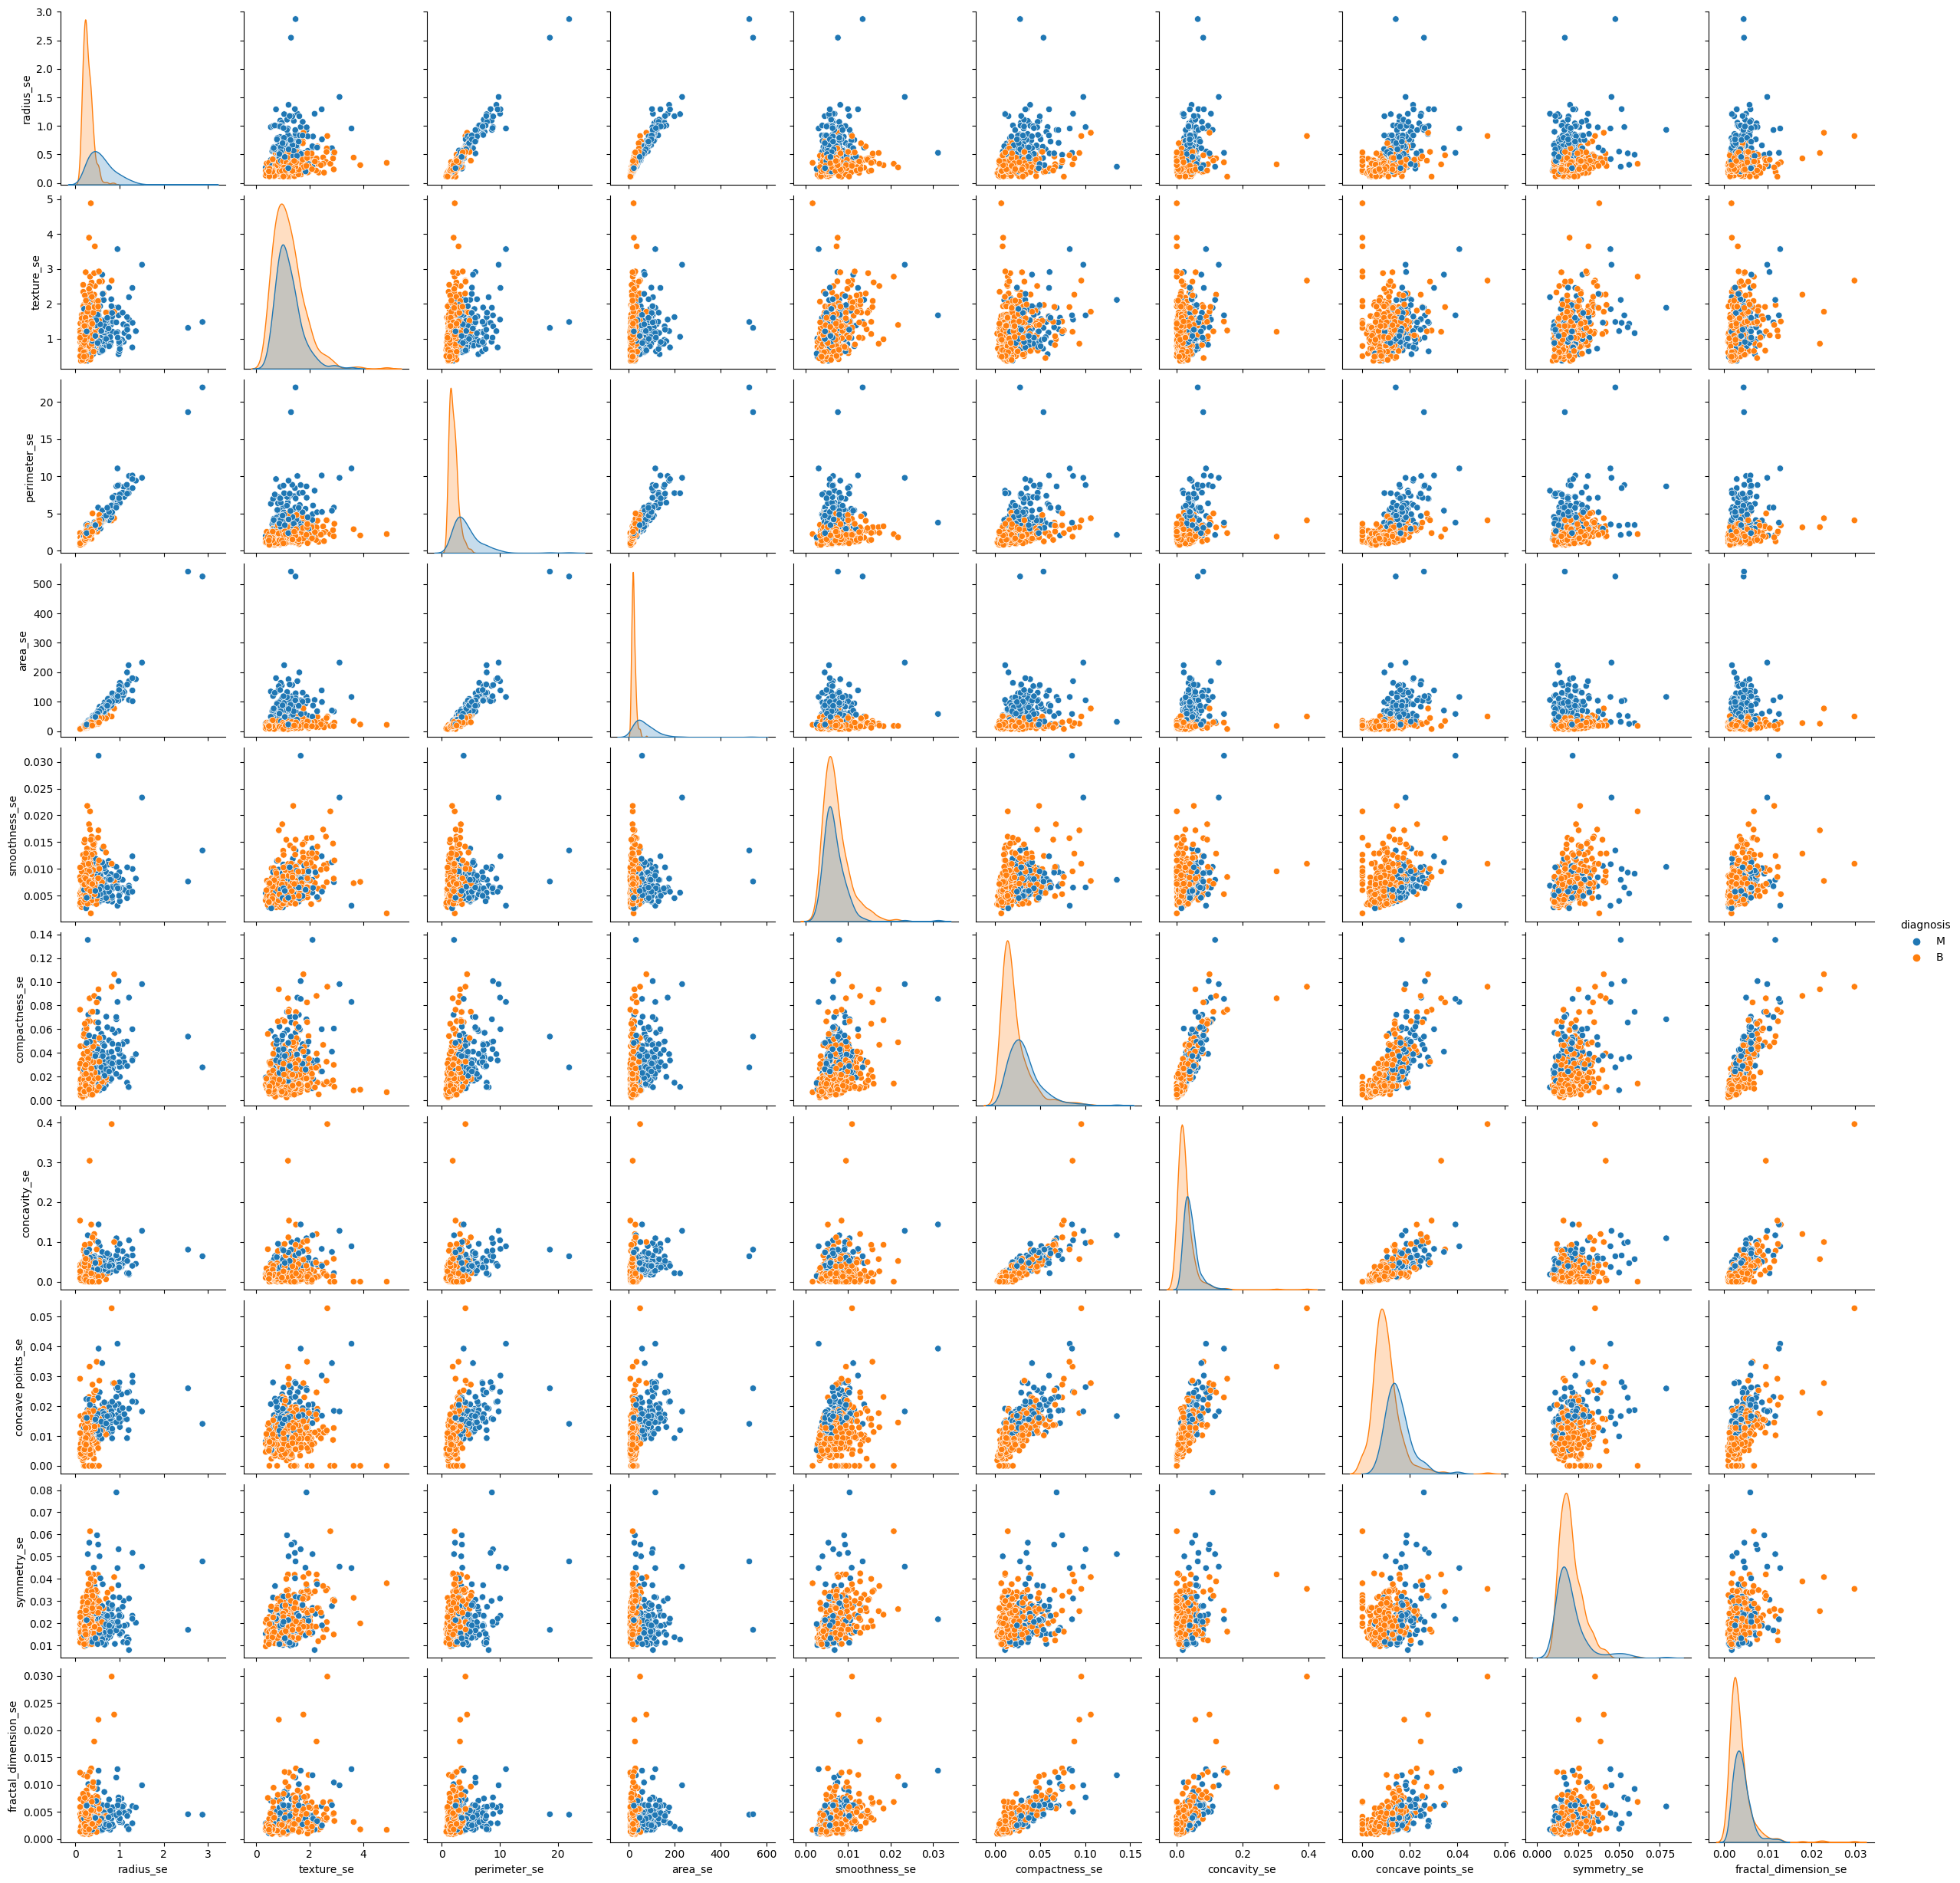

In [43]:
# Let's look at the pair dependencies of the 2 group variables.
sns.pairplot(data=df[std_vars + ['diagnosis']], hue='diagnosis')

**Conclusion:** We can see that there are a number of variables based on which we can good enough classify the target value

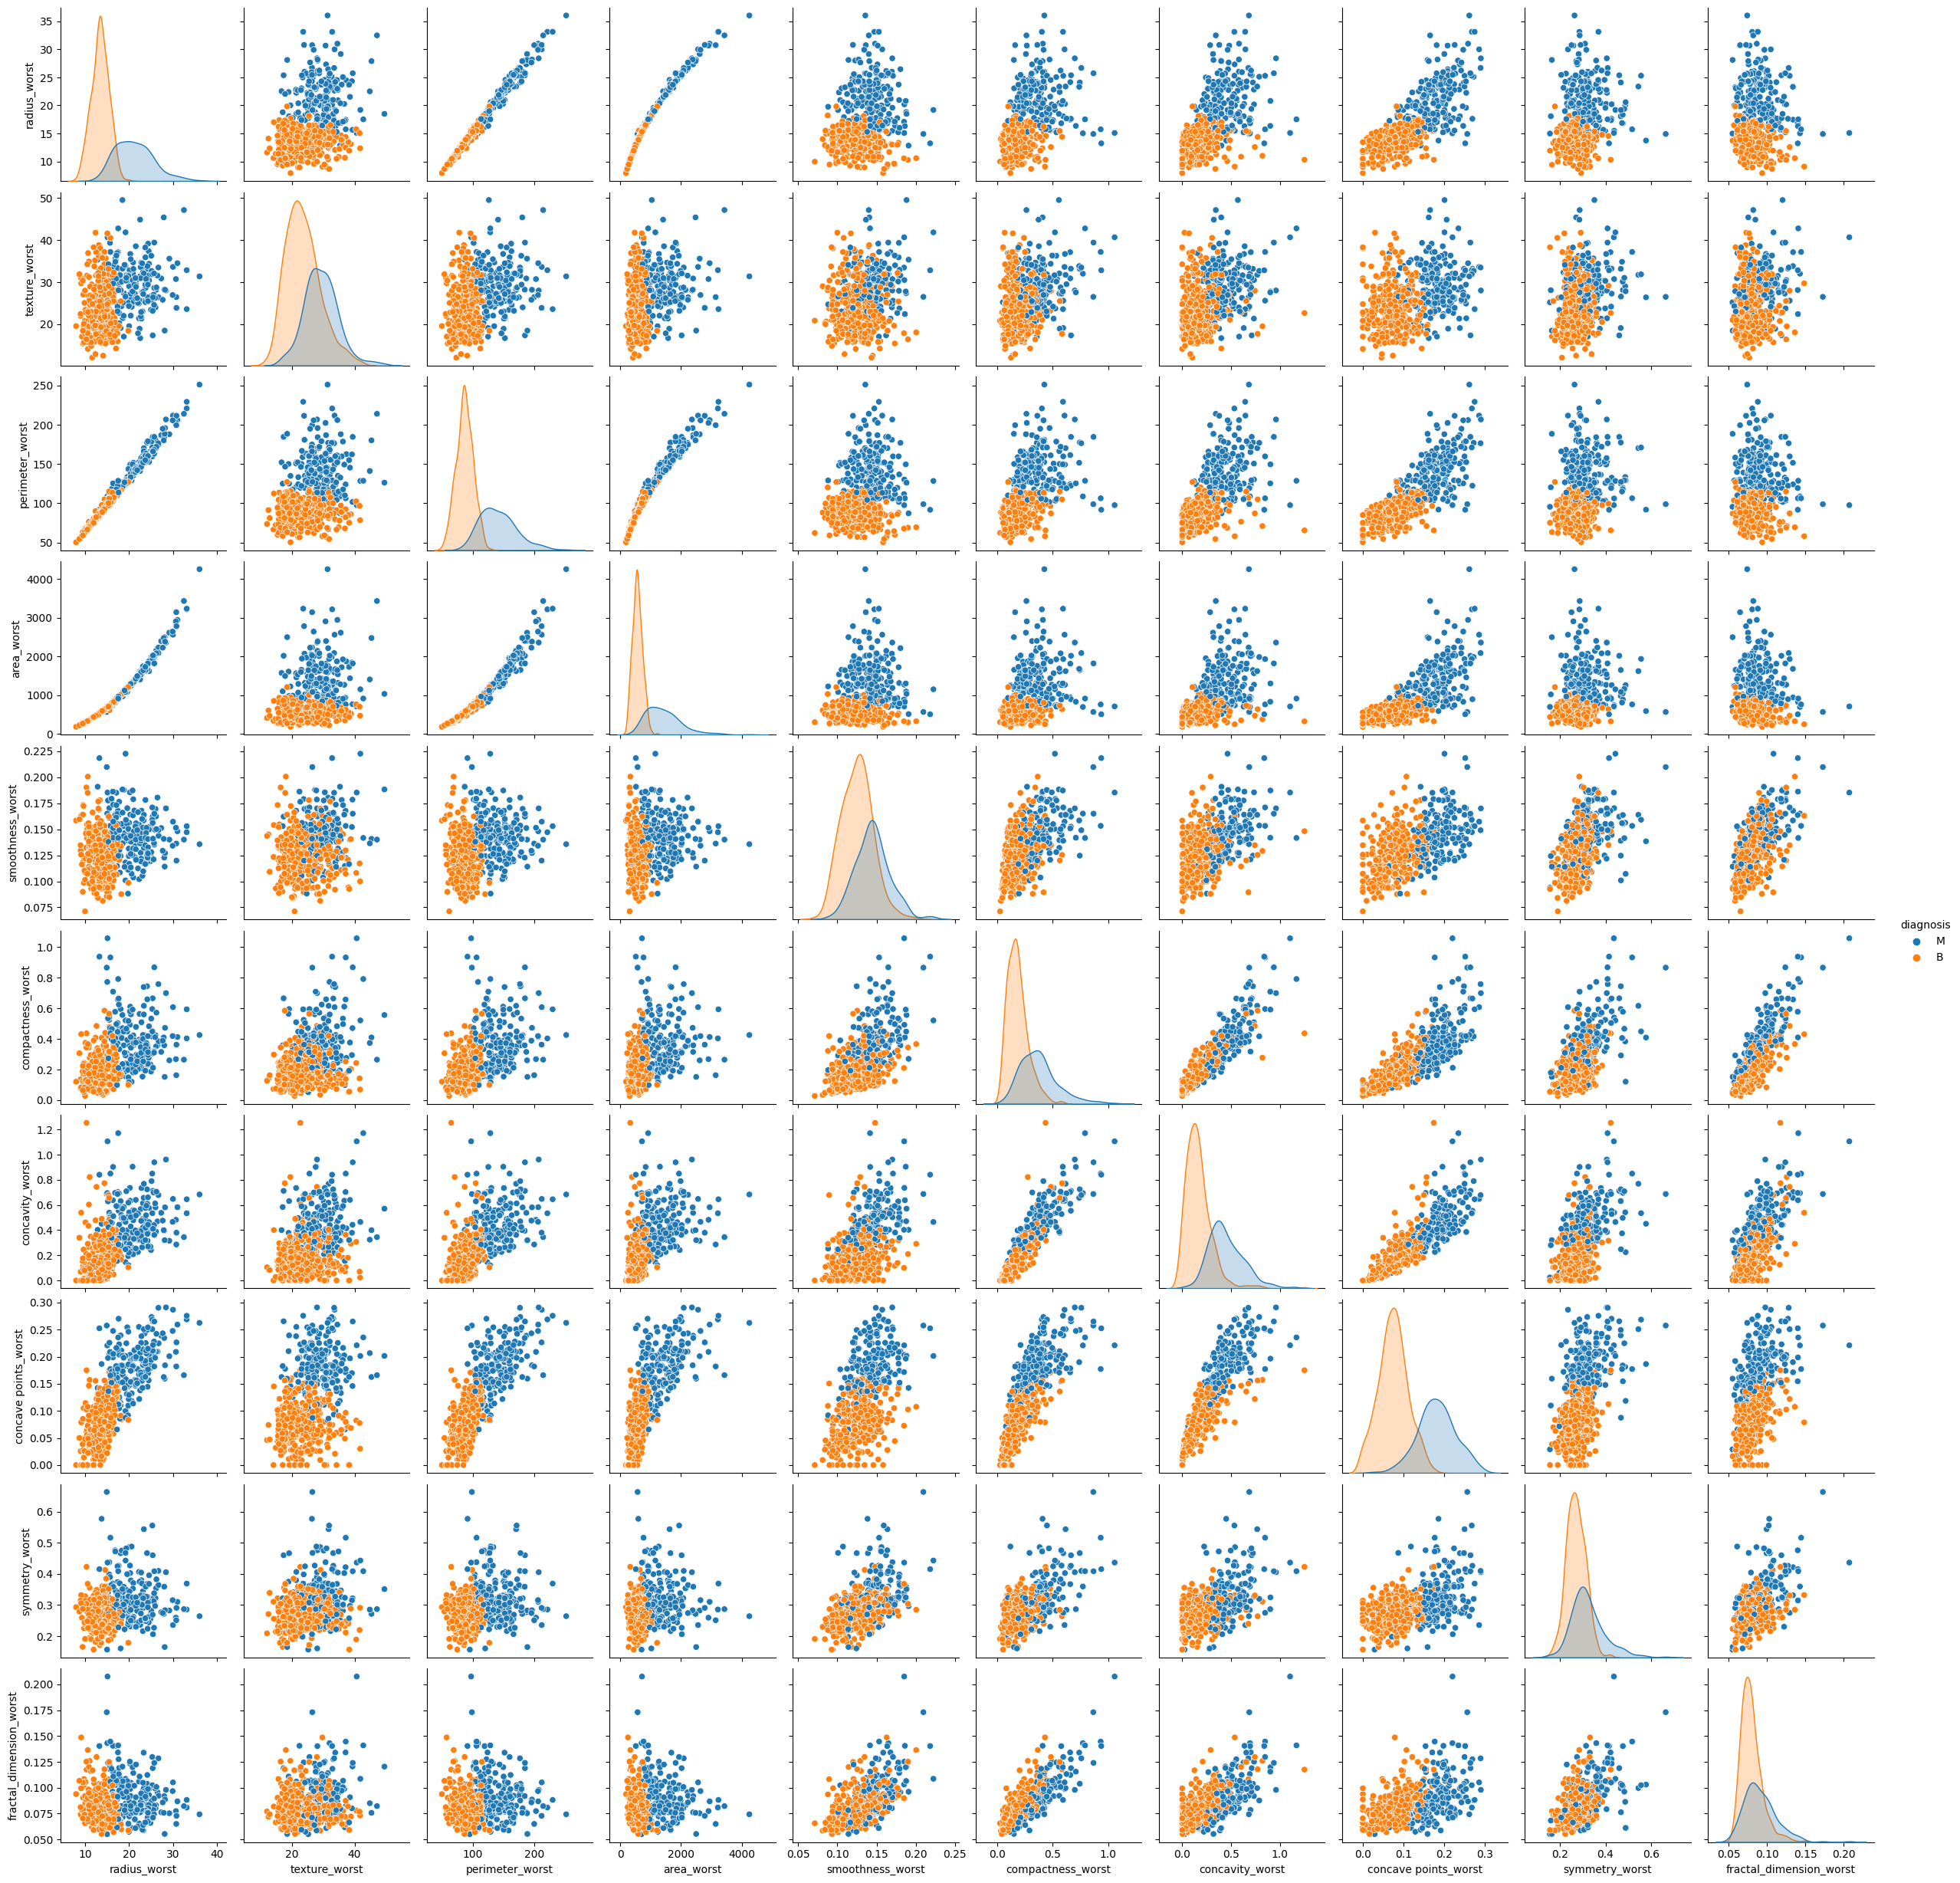

In [44]:
# Let's look at the pair dependencies of the 3 group variables.
sns.pairplot(data=df[worst_vars + ['diagnosis']], hue='diagnosis')

**Conclusion:** We can see these distribution are similar to the distributions of *_mean variables. Maybe we can use in classification only one set. Let's figure out this.

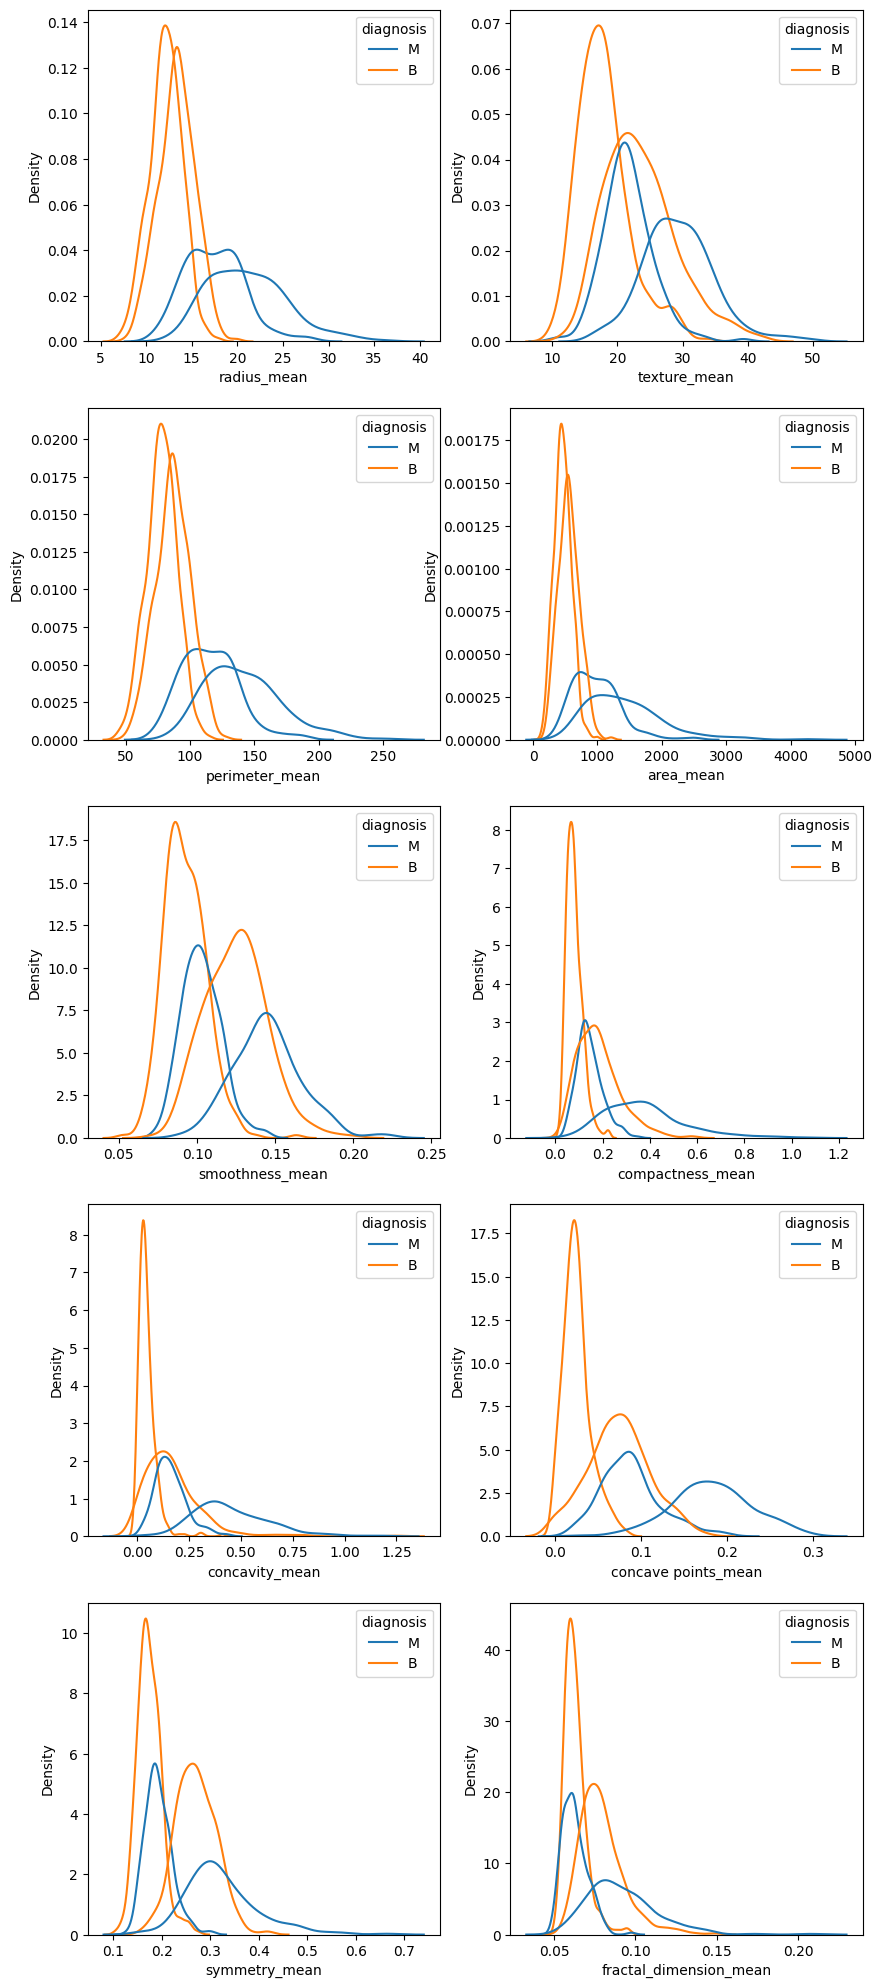

In [74]:
# We want to compare the distributions of the *_mean variables and the *_worst variables with respect to the target variable
n = len(mean_vars)
_, axs = plt.subplots(n//2, 2, figsize=(10, 5*n//2)) # it will be a grid with size n//2 to 2

# we're going to depict the *_mean variable and corresponding to it the *_worst variables on the same plot
for idx, cols in enumerate(zip(mean_vars, worst_vars)):
  sns.kdeplot(data=df, x=cols[0], hue='diagnosis', ax=axs[idx//2][idx%2])
  sns.kdeplot(data=df, x=cols[1], hue='diagnosis', ax=axs[idx//2][idx%2])

**Conclusion:** The following variables have the similar distribution:
  - radius_mean and radius_worst
  - perimeter_mean and perimeter_worst
  - area_mean and area_worst

So, we can use only one variable from every pair.

# 3. Label encoding of target variable

In [75]:
df.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [76]:
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])

In [77]:
le.classes_

array(['B', 'M'], dtype=object)

# 4. Features scaling and split dataset

In [78]:
X = df.iloc[:, 2:].values
y = df['diagnosis'].values

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [80]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 5. Make classification



## 5.1. Classification using all variables

In [81]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [82]:
y_hat = clf.predict(X_test)

In [83]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        88
           1       0.98      0.95      0.96        55

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



<Axes: >

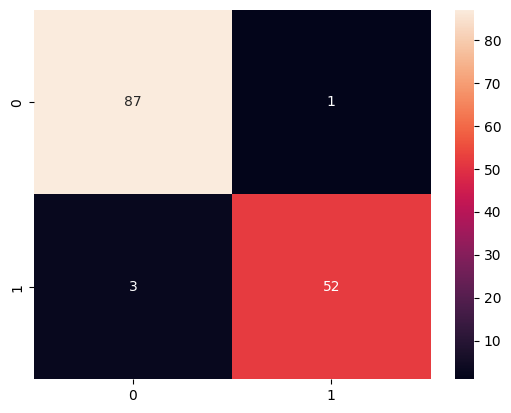

In [84]:
cm = confusion_matrix(y_test, y_hat)
sns.heatmap(cm, annot=True)

**Conclusion:** We've achieved a good results. But we used all independent variables. In the [section 2](https://colab.research.google.com/drive/1puXdrMrvdF_S6aTxv1eBKi9gx2kB1kg7#scrollTo=XarjQ1kfLasa&line=1&uniqifier=1) we've figured out that there are a number of dependencies between variables in the dataset. Taking this into account let's try to reduce the number of using variables.

## 5.2. Classification using a fewer number of variables

In [85]:
excluded_vars = ['perimeter_mean', 'concave points_mean', 'compactness_mean', 'radius_worst', 'perimeter_worst', 'area_worst']

In [88]:
excluded_column_numbers = [idx for idx, col in enumerate(num_vars) if col in excluded_vars]
excluded_column_numbers

[2, 5, 7, 20, 22, 23]

In [90]:
def reduce_X(X, excluded_column_numbers):
  return np.delete(X, excluded_column_numbers, 1)

In [107]:
X_train_reduce_1 = reduce_X(X_train, excluded_column_numbers)
X_test_reduce_1 = reduce_X(X_test, excluded_column_numbers)

In [108]:
X_train_reduce_1.shape

(426, 24)

In [109]:
clf = LogisticRegression()
clf.fit(X_train_reduce_1, y_train)
y_hat = clf.predict(X_test_reduce_1)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        88
           1       1.00      0.93      0.96        55

    accuracy                           0.97       143
   macro avg       0.98      0.96      0.97       143
weighted avg       0.97      0.97      0.97       143



<Axes: >

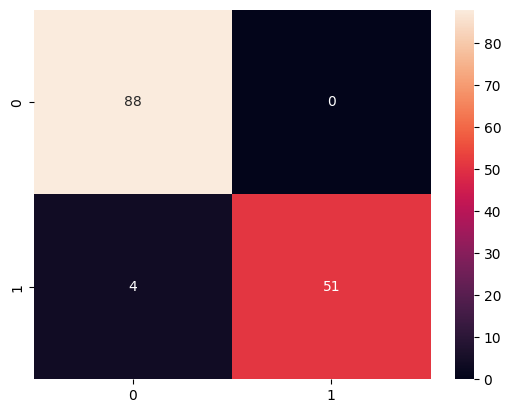

In [110]:
cm = confusion_matrix(y_test, y_hat)
sns.heatmap(cm, annot=True)

# 6. Takeaways

We got a very similar result: 4 misclassified samples using all variable and 4 misclassified samples using 6 fewer variables and we've chosen these 6 variables based only on the EDA. It's a good result because it means reducing time and other costs.